In [16]:
import open3d as o3d
import numpy as np

def load_off_as_voxel(off_path, grid_size=64):
    # 读取三角网格
    mesh = o3d.io.read_triangle_mesh(off_path)
    if not mesh.has_triangles():
        print(f"[Warning] Mesh has no triangles: {off_path}")
        return None

    # 均匀采样成点云
    pcd = mesh.sample_points_uniformly(number_of_points=2048)
    points = np.asarray(pcd.points)

    # 归一化到单位立方体
    centroid = np.mean(points, axis=0)
    points -= centroid
    scale = np.max(np.linalg.norm(points, axis=1))
    points /= scale
    points += 0.5  # 平移到 [0, 1] 区间
    points = np.clip(points, 0, 0.9999)

    # 转成体素网格（occupancy grid）
    voxel_grid = np.zeros((grid_size, grid_size, grid_size), dtype=np.uint8)
    voxel_coords = (points * grid_size).astype(int)
    voxel_grid[voxel_coords[:, 0], voxel_coords[:, 1], voxel_coords[:, 2]] = 1

    return voxel_grid


In [17]:
import os
from tqdm import tqdm

def build_voxel_dataset(root_dir, grid_size=32, split='train'):
    classes = sorted(os.listdir(root_dir))
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

    data = []
    labels = []

    for cls_name in tqdm(classes, desc=f"Processing {split} data"):
        split_dir = os.path.join(root_dir, cls_name, split)
        for file in os.listdir(split_dir):
            if file.endswith(".off"):
                file_path = os.path.join(split_dir, file)
                voxel = load_off_as_voxel(file_path, grid_size=grid_size)
                if voxel is not None:
                    data.append(voxel)
                    labels.append(class_to_idx[cls_name])

    return np.array(data), np.array(labels), class_to_idx


In [18]:
import os
from tqdm import tqdm

root_dir = "E:/graphics/3DProject/ModelNet10"
X_train, y_train, class_map = build_voxel_dataset(root_dir, grid_size=64, split="train")
X_test, y_test, _ = build_voxel_dataset(root_dir, grid_size=64, split="test")

np.save("train_voxels.npy", X_train)
np.save("train_labels_vox.npy", y_train)
np.save("test_voxels.npy", X_test)
np.save("test_labels_vox.npy", y_test)

import json
with open("class_map.json", "w") as f:
    json.dump(class_map, f)


Processing test data: 100%|██████████| 10/10 [00:23<00:00,  2.34s/it]


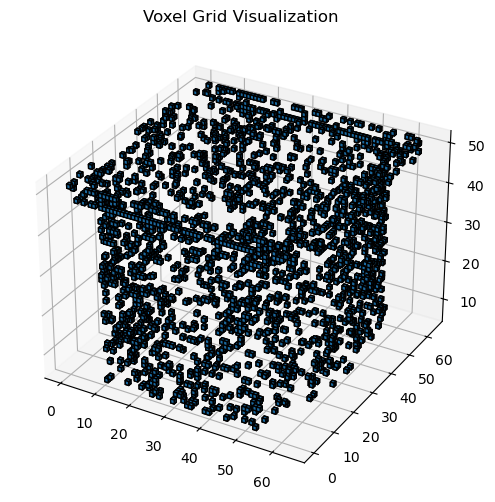

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_voxel(voxel):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(voxel, edgecolor='k')
    plt.title("Voxel Grid Visualization")
    plt.show()
# 加载一个体素样本
X_train = np.load("train_voxels.npy")
visualize_voxel(X_train[1])


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import json

class VoxelDataset(Dataset):
    def __init__(self, voxel_path, label_path):
        self.data = np.load(voxel_path)
        self.labels = np.load(label_path)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = self.data[idx][None, :, :, :]  # 添加通道维度 C=1
        y = self.labels[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)



In [ ]:
class Simple3DCNN(nn.Module):
    def __init__(self, num_classes):
        super(Simple3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool3d(2)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool3d(2)
        self.adapt = nn.AdaptiveAvgPool3d((8, 8, 8))  # 🔥 统一输出体积大小
        self.fc1 = nn.Linear(64 * 8 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))     
        x = self.pool2(F.relu(self.conv2(x)))     
        x = self.adapt(x)                         
        x = x.view(x.size(0), -1)                 
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [25]:
# 加载数据
train_set = VoxelDataset("train_voxels.npy", "train_labels_vox.npy")
test_set = VoxelDataset("test_voxels.npy", "test_labels_vox.npy")
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=16)

# 加载类别映射
with open("class_map.json") as f:
    class_map = json.load(f)
idx_to_class = {v: k for k, v in class_map.items()}


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Simple3DCNN(num_classes=len(class_map)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 训练
epochs = 10
train_losses = []
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"[Epoch {epoch+1}] Loss: {avg_loss:.4f}")


[Epoch 1] Loss: 0.4947
[Epoch 2] Loss: 0.2110
[Epoch 3] Loss: 0.1281
[Epoch 4] Loss: 0.0717
[Epoch 5] Loss: 0.0604
[Epoch 6] Loss: 0.0452
[Epoch 7] Loss: 0.0461
[Epoch 8] Loss: 0.0279
[Epoch 9] Loss: 0.0342
[Epoch 10] Loss: 0.0201


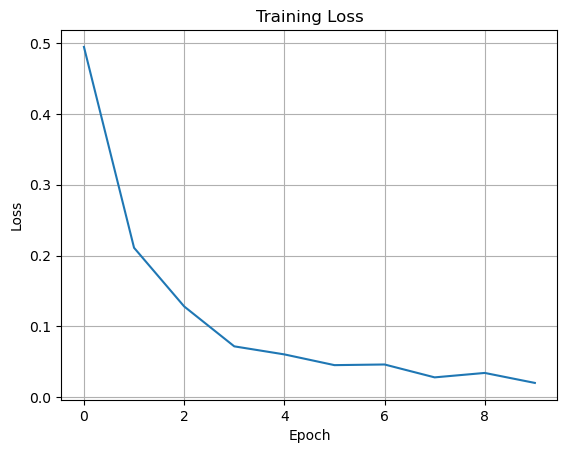

In [27]:
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


              precision    recall  f1-score   support

     bathtub       1.00      0.88      0.94        50
         bed       0.90      1.00      0.95       100
       chair       0.98      0.97      0.97       100
        desk       0.57      0.85      0.68        86
     dresser       0.81      0.77      0.79        86
     monitor       0.98      0.99      0.99       100
 night_stand       0.73      0.77      0.75        86
        sofa       0.98      0.95      0.96       100
       table       0.88      0.53      0.66       100
      toilet       0.98      0.94      0.96       100

    accuracy                           0.87       908
   macro avg       0.88      0.86      0.86       908
weighted avg       0.88      0.87      0.87       908



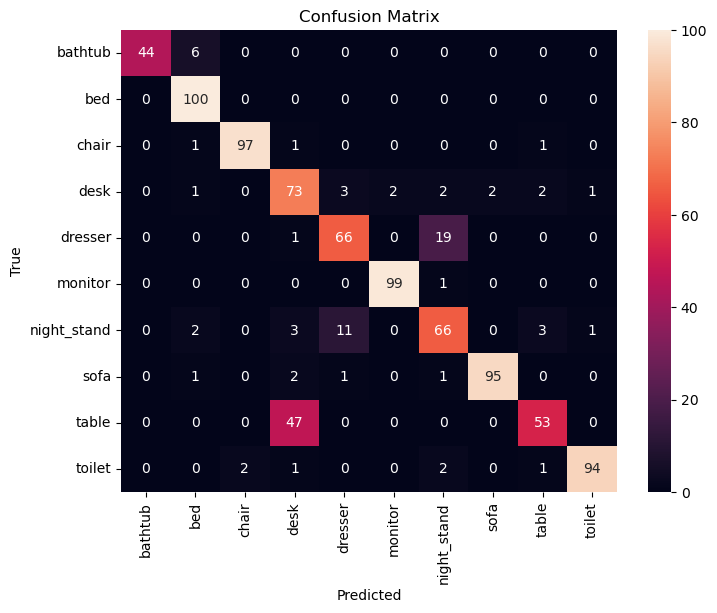

In [28]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        out = model(x)
        preds = out.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y.numpy())

# 分类报告
print(classification_report(all_labels, all_preds, target_names=[idx_to_class[i] for i in range(len(class_map))]))

# 混淆矩阵
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_map.keys(), yticklabels=class_map.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
